In [1]:
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from decision_tree_v2 import *

In [2]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

## Analyze by describing data
### which features are available

In [3]:
print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


### which features are categorical
These values classify the samples into sets of similar samples. Within categorical features are the values **nominal***(无序的), **ordinal**(有序的), **ratio**, or **interval** based?  
- **Categorical**: Survived, Sex, and Embarked. **Ordinal**: Pclass

### which features are numerical
Within numerical features are the values **discrete**, **continuous**, or **timeseries** based? 
- Continuous: Age, Fare. Discrete: SibSp, Parch

In [4]:
# preview the data
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### which features are mixed data types
Numerical, alphanumeric data within same feature. These are candidates for **correcting** goal.
- Ticket is a mix of numeric and alphanumeric data types. Cabin is alphanumeric.

### which features may contain errors or typos
This is harder to review for a large dataset, however reviewing a few samples from a smaller dataset may just tell us outright, which features may require **correcting**.
- Name feature may contain errors or typos as there are several ways used to describe a name including titles, round brackets, and quotes used for alternative or short names.

In [5]:
train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


### which features contain blank, null or empty values
These will require **correcting**.
- Cabin > Age > Embarked features contain a number of null values in that order for the training dataset.
- Cabin > Age > Fare are incomple in case of test dataset.

In [6]:
train_df.isna().sum() / len(train_df)

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

In [7]:
test_df.isna().sum() / len(test_df)

PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.205742
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.002392
Cabin          0.782297
Embarked       0.000000
dtype: float64

### what are the data types for various features?
Helping us during **converting** goal.
- Seven features are integer or floats. Six in case of test dataset.
- Five features are strings(object)

In [8]:
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

### what is the distribution of numerical feature values across the samples
This helps us determine, among other early insights, how **representative** is the training dataset of the actual problem domain.
- Total samples are 891 or 40% of the actual number of passengers on board the Titanic (2224)
- Surived is a categorical feature with 0 or 1 values
- Around 38% samples survived representative of the actual survival rate at  32%
- Most passengers(> 75%) did not travel with parents or children
- Nearly 30% of the passengers had siblings and/or spouse aboard
- Fares varied significantly with few passengers (<1%) paying as high as $512
- Few elderly passengers(< 0.01) within age range 65-80

In [9]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
train_df['Survived'].quantile([.61, .62])

0.61    0.0
0.62    1.0
Name: Survived, dtype: float64

In [11]:
train_df['Parch'].quantile([.75, .8])

0.75    0.0
0.80    1.0
Name: Parch, dtype: float64

In [12]:
train_df['SibSp'].quantile([.68, .69])

0.68    0.0
0.69    1.0
Name: SibSp, dtype: float64

In [13]:
train_df['Age'].quantile([.1, .2, .3, .4, .5, .6, .7, .8, .9, .99])

0.10    14.00
0.20    19.00
0.30    22.00
0.40    25.00
0.50    28.00
0.60    31.80
0.70    36.00
0.80    41.00
0.90    50.00
0.99    65.87
Name: Age, dtype: float64

In [14]:
train_df['Fare'].quantile([.1, .2, .3, .4, .5, .6, .7, .8, .9, .99])

0.10      7.55000
0.20      7.85420
0.30      8.05000
0.40     10.50000
0.50     14.45420
0.60     21.67920
0.70     27.00000
0.80     39.68750
0.90     77.95830
0.99    249.00622
Name: Fare, dtype: float64

### what is the distribution of categorical features
- Names are unique across the dataset (count = unique = 891)
- Sex variable as two possible values with 65% male
- Cabin values have several duplicates across samples. Alternatively several passengers shared a cabin
- Embarked takes three possible values. S port used by most passengers
- Ticket feature has high ratio(22%) of duplicate values (unique = 681)

In [15]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Walker, Mr. William Anderson",male,CA. 2343,B96 B98,S
freq,1,577,7,4,644


In [16]:
train_df['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [17]:
train_df['Ticket'].value_counts()

CA. 2343             7
1601                 7
347082               7
347088               6
CA 2144              6
                    ..
STON/O 2. 3101275    1
C 7076               1
A.5. 11206           1
345781               1
3411                 1
Name: Ticket, Length: 681, dtype: int64

In [18]:
train_df['Cabin'].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
E101           3
D              3
              ..
C90            1
B82 B84        1
A34            1
C103           1
D48            1
Name: Cabin, Length: 147, dtype: int64

In [19]:
train_df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

## Assumptions based on data analysis
We arrive at following assumptions based on data analysis done so far. We may validate these assumptions further before taking appropriate actions.

### Correlating
We want to know how well does each feature correlate with Survival. We want to do this early in our poject match these quick correlations with modelled correlations later in the project.

### Completing
- We may want to complete Age feature as it is definitely correlated to survival.
- We may want to complete the Embarked feature as it may also correlate with survival or another important feature.

### Correcting
- Ticket feature may be dropped from our analysis as it contains high ratio of duplicates (22%) and there may not be a correlation between Ticket and survival.
- Cabin feature may be dropped as it is highly incomplete or contains many null values both in training and test dataset.
- PassengerId may be dropped from training dataset as it does not contribute to survival.
- Name feature is relatively non-standard, may not contribute directly to survival, so maybe dropped.

### Creating
- We may want to create a new feature called Family based on Parch and SibSp to get total count of family members on board.
- We may want to engineer the Name feature to extract TiTle as a new feature.
- We may want to create new feature for Age bands. This turns a continuous numerical feature into an ordinal categorical feature.
- We may also want to create a Fare range feature if it helps our analysis.

### Classifying
We may also add to our assumptions based on the problem description noted earlier. 
- Women(Sex = female) were more likely to have survived.
- Children (Age < ?) were more likely to have survived.
- The upper-class passengers (Pclass = 1) were more likely to have survived.

## Analyze by pivoting features
To confirm some of our observations and assumptions, we can quickly analyze our feature correlations by **pivoting** features against each other. We can only do so at this stage for features which do not have any empty values. It also makes sense doing so only for features which are categorical(Sex), ordinal(Pclass) or discrete(SibSp, Parch) type.
- **Pclass** We observe significant correlation (> 0.5) among Pclass = 1 and Survived. We decide to include this feature in our model.(classifying #3)
- **Sex** We confirm the observation during problem definition that Sex = female had very high survival rate at 74%. (clasifying #1)
- **SibSp and Parch** These features have zero correlation for certain values. It may be best to derive a feature or a set of features from these individual features (creating #1)

In [20]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], 
                                         as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [21]:
train_df[['Sex', 'Survived']].groupby(['Sex'], 
                                         as_index = False).mean().sort_values(by = 'Survived', ascending = False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [22]:
train_df[['SibSp', 'Survived']].groupby(['SibSp'], 
                                        as_index=False).mean().sort_values(by = 'Survived', ascending = False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [23]:
train_df[['Parch', 'Survived']].groupby(['Parch'], 
                                       as_index=False).mean().sort_values(by = 'Survived', ascending = False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


## Analyze by visualizing data
Now we can continue confirming some of our assumptions using visualizations for analyzing the data.

### Correlating numerical features
Let us start by understanding correlations between numerical features and our solution goal(Survived).

A histogram chart is useful for analyzing continuous numerical variables like Age where **banding** or **ranges** will help identify useful patterns. The histogram can indicate distribution of samples using automatically defined bins or equally ranged bands. This helps us answer questions relating to specific bands (Did infants have better survival rate?)

**Observations**
- Infants(Age <= 4) had high survival rate.
- Oldest passengers(Age = 80) survived.
- Large number of 15-25 year olds did not survive.
- Most passengers are in 15-35 age range.

**Decisions**
- We should consider Age(our assumption classifying #2) in our model training.
- Complete the Age feature for null values (completing #1).
- We should band age groups (creating #3) (我们使用 histogram 可以观测到不同组之间的差异，在这里我们可以发现 infant 更容易 survivem, 也就是说 survive 与否并不是与连续变量 Age 线性相关，而是某些组相对其他组更容易 survive，所以需要将连续型变量 Age 转换成进行分组)

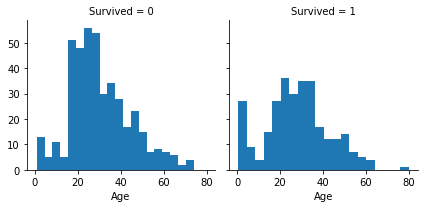

In [24]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

### Correlating numerical and ordinal features
We can combine multiple features for identifying correlations using a single plot. This can be done with numerical and categorical features which have numeric values.
**Observations**
- Pclass = 3 had most passengers, however most did not survive. Confirms our classifying assumption #2.
- Infant passengers in Pclass = 2 and Pclass = 3 mostly survived. Further qualifies our classifying assumption #2.
- Most passengers in Pclass = 1 survived. Confirms our classifying assumption #3.
- Pclass varies in terms of Age distribution of passengers.

**Decisions**
- Consider Pclass for model training.

/Users/starfly/miniforge3/lib/python3.9/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


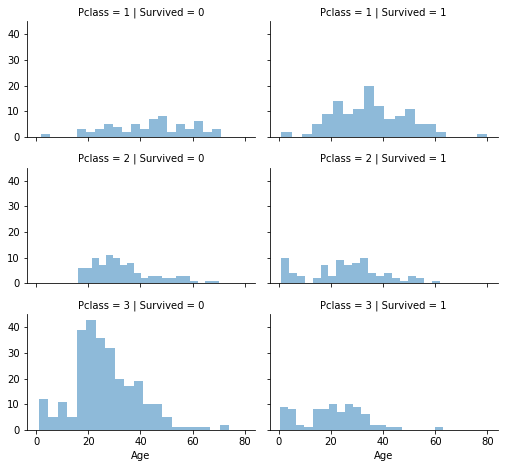

In [25]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Survived')
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

### Correlating categorical features
Now we can correlate categorical features with our solution goal.
**Observations**
- Female passengers had much better survival rate than males. Confirms classifying (#1).
- Exception in Embarked = C where males had higher survival rate. This could be a correlation between Pclass and Embarked and in turn Pclass and Survived, not necessarily direct correlation between Embarked and Survived.
- Males had better survival rate in Pcalss = 3 when compared with Pclass = 2 for C and Q ports. Completing(#2)
- Ports of embarkation have varying survival rates for Pclass = 3 and among male passengers. Correlating (#1)

**Decisions**
- Add Sex feature to model training.
- Complete and add Embarked feature to model training.

/Users/starfly/miniforge3/lib/python3.9/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/starfly/miniforge3/lib/python3.9/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/starfly/miniforge3/lib/python3.9/site-packages/seaborn/axisgrid.py:648: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


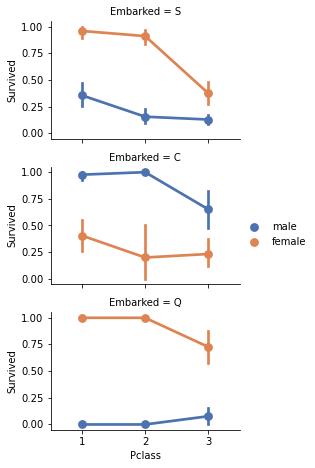

In [26]:
# grid = sns.FacetGrid(train_df, col='Embarked')
grid = sns.FacetGrid(train_df, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

### Correlating categorical and numerical features
We may also want to correlate categorical features(with non-numeric values) and numeric features. We can consider correlating Embarked (Categorical non-numeric), Sex (Categorical non-numeric), Fare (Numeric continuous), with Survived (Categorical numeric)

**Observations**

Higher fare paying passengers had better survival. Confirms our assumption for creating (#4) fare ranges.
Port of embarkation correlates with survival rates. Confirms correlating (#1) and completing (#2).

**Decisions**

Consider banding Fare feature.

/Users/starfly/miniforge3/lib/python3.9/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/starfly/miniforge3/lib/python3.9/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


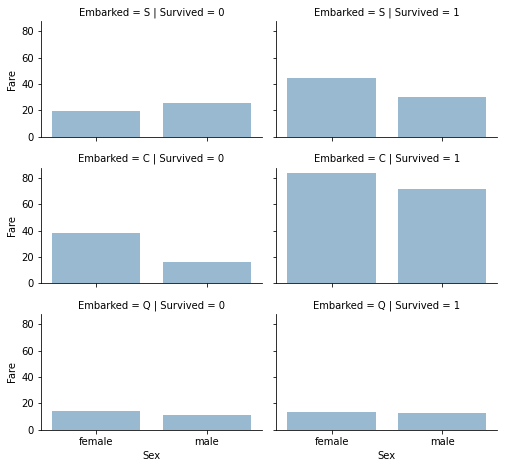

In [27]:
# grid = sns.FacetGrid(train_df, col='Embarked', hue='Survived', palette={0: 'k', 1: 'w'})
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

## Wrangle data
We have collected several assumptions and decisions regarding our datasets and solution requirements. So far we did not have to change a single feature or value to arrive at these. Let us now execute our decisions and assumptions for correcting, creating and completing goals.

### Correcting by dropping features
This is a good starting goal to execute. By dropping features we are dealing with fewer data points. Speeds up our notebook and eases the analysis.

Based on our assumptions and decisions we want to drop the Cabin(correcting #2) and Ticket(correcting #1) features.

Note that where applicable we perform operations on both training and testing datasets together to stay consistent.

In [28]:
print("Before", train_df.shape, test_df.shape)

train_df = train_df.drop(['Ticket', 'Cabin'], axis = 1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis = 1)

print("After", train_df.shape, test_df.shape)

combine = [train_df, test_df]

Before (891, 12) (418, 11)
After (891, 10) (418, 9)


### Creating new feature extracting from existing
We want to analyze if Name feature can be engineered to extract titles and test correlation between titiles and survival, before dropping Name and PassengerId features.

**Observations**

When we plot Title, Age, and Survived, we note the following observations.

Most titles band Age groups accurately. For example: Master title has Age mean of 5 years.
Survival among Title Age bands varies slightly.
Certain titles mostly survived (Mme, Lady, Sir) or did not (Don, Rev, Jonkheer).

**Decision**

We decide to retain the new Title feature for model training.

In [29]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    
pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [30]:
# we can replace many titles with a more common name or classify them as Rare.
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [31]:
# we can convert the categorical titles to ordinal
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


In [32]:
# now we can drop the name feature
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

((891, 9), (418, 9))

### Converting a categorical feature
Now we can convert features which contain strings to numerical values. This is required by most model algorithms. Doing so will also help us in achieving the feature completing goal.

Let us start by converting Sex feature to a new feature called Gender where female=1 and male=0.（决策树不需要）

In [33]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

### Completing a numerical continuous feature
Now we should start estimating and completing features with missing or null values. We will first do this for the Age feature.

We can consider three methods to complete a numerical continuous feature.

- 1. A simple way is to generate random numbers between mean and standard deviation.

- 2. More accurate way of guessing missing values is to use other correlated features. In our case we note correlation among Age, Gender, and Pclass. Guess Age values using median values for Age across sets of Pclass and Gender feature combinations. So, median Age for Pclass=1 and Gender=0, Pclass=1 and Gender=1, and so on...

- 3. Combine methods 1 and 2. So instead of guessing age values based on median, use random numbers between mean and standard deviation, based on sets of Pclass and Gender combinations.

Method 1 and 3 will introduce random noise into our models. The results from multiple executions might vary. We will prefer method 2. (决策树可以不用填补缺失值)

/Users/starfly/miniforge3/lib/python3.9/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


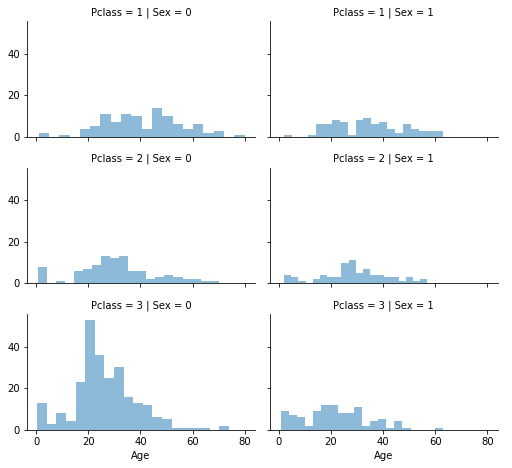

In [34]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Gender')
grid = sns.FacetGrid(train_df, row='Pclass', col='Sex', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

Let us start by preparing an empty array to contain guessed Age values based on Pclass * Gender combinations

In [35]:
guess_ages = np.zeros((2,3))
guess_ages

array([[0., 0., 0.],
       [0., 0., 0.]])

In [36]:
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,3
2,1,3,1,26,0,0,7.9250,S,2
3,1,1,1,35,1,0,53.1000,S,3
4,0,3,0,35,0,0,8.0500,S,1


In [37]:
# let us create age bands and determine correlations with Survived.
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], 
                                          as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


In [38]:
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,0,1,1,0,7.2500,S,1,"(16.0, 32.0]"
1,1,1,1,2,1,0,71.2833,C,3,"(32.0, 48.0]"
2,1,3,1,1,0,0,7.9250,S,2,"(16.0, 32.0]"
3,1,1,1,2,1,0,53.1000,S,3,"(32.0, 48.0]"
4,0,3,0,2,0,0,8.0500,S,1,"(32.0, 48.0]"


In [39]:
# we can now remove the AgeBand feature
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1
1,1,1,1,2,1,0,71.2833,C,3
2,1,3,1,1,0,0,7.9250,S,2
3,1,1,1,2,1,0,53.1000,S,3
4,0,3,0,2,0,0,8.0500,S,1


### Create new feature combining existing features
We can create a new feature for FamilySize which combines Parch and SibSp. This will enable us to drop Parch and SibSp from our datasets.

In [40]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [41]:
# We can create another feature called isAlone.
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [42]:
# let us drop Parch, SibSp and FamilySize features in favor of IsAlone.
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,7.2500,S,1,0
1,1,1,1,2,71.2833,C,3,0
2,1,3,1,1,7.9250,S,2,1
3,1,1,1,2,53.1000,S,3,0
4,0,3,0,2,8.0500,S,1,1


In [43]:
# we can also create an artificial feature combining Pclass and Age.
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2


### Completing a categorical feature
Embarked feature takes S, Q, C values based on port of embarkation. Our training dataset has two missing values. We simply fill these with the most common occurance.

In [44]:
freq_port = train_df.Embarked.dropna().mode()[0]
freq_port

'S'

In [45]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


### Converting categorical feature to numeric
We can now convert the EmbarkedFill feature by creating a new numeric Port feature.(决策树不需要)

In [46]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,7.2500,0,1,0,3
1,1,1,1,2,71.2833,1,3,0,2
2,1,3,1,1,7.9250,0,2,1,3
3,1,1,1,2,53.1000,0,3,0,2
4,0,3,0,2,8.0500,0,1,1,6


### Quick completing and converting a numeric feature
We can now complete the Fare feature for single missing value in test dataset using mode to get the value that occurs most frequently for this feature. We do this in a single line of code.

Note that we are not creating an intermediate new feature or doing any further analysis for correlation to guess missing feature as we are replacing only a single value. The completion goal achieves desired requirement for model algorithm to operate on non-null values.

We may also want round off the fare to two decimals as it represents currency.

In [47]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,7.8292,2,1,1,6
1,893,3,1,2,7.0000,0,3,0,6
2,894,2,0,3,9.6875,2,1,1,6
3,895,3,0,1,8.6625,0,1,1,3
4,896,3,1,1,12.2875,0,3,0,3


In [48]:
# we can now create FareBand
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], 
                                           as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [49]:
# convert the fare feature to ordinal values based on the FareBand.
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]
    
train_df.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,0,0,1,0,3
1,1,1,1,2,3,1,3,0,2
2,1,3,1,1,1,0,2,1,3
3,1,1,1,2,3,0,3,0,2
4,0,3,0,2,1,0,1,1,6
5,0,3,0,1,1,2,1,1,3
6,0,1,0,3,3,0,1,1,3
7,0,3,0,0,2,0,4,0,0
8,1,3,1,1,1,0,3,0,3
9,1,2,1,0,2,1,3,0,0


In [50]:
test_df.head(10)

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,0,2,1,1,6
1,893,3,1,2,0,0,3,0,6
2,894,2,0,3,1,2,1,1,6
3,895,3,0,1,1,0,1,1,3
4,896,3,1,1,1,0,3,0,3
5,897,3,0,0,1,0,1,1,0
6,898,3,1,1,0,2,2,1,3
7,899,2,0,1,2,0,1,0,2
8,900,3,1,1,0,1,3,1,3
9,901,3,0,1,2,0,1,0,3


## Model, predict and solve

In [51]:
train = train_df.iloc[:, [1, 2, 3, 4, 5, 6, 7, 8, 0]]
test = test_df.iloc[:, 1:]

tree = DecisionTree(min_leaf_size=10, max_depth=5)
print(cross_validation_score(tree, train))

79.6629213483146


In [52]:
tree.print_tree()

 [Title = 1]
  [Pclass = 1]
   [Age = 3]
    [Embarked = 0]
     [Pclass = 1]
      [0]
      [0]
     [0]
    [Fare = 2]
     [Embarked = 1]
      [0]
      [1]
     [IsAlone = 1]
      [0]
      [0]
   [Fare = 1]
    [Age*Class = 4]
     [0]
     [Embarked = 1]
      [0]
      [0]
    [Age*Class = 3]
     [Fare = 3]
      [1]
      [0]
     [Age = 1]
      [0]
      [0]
  [Pclass = 3]
   [Embarked = 0]
    [Fare = 3]
     [Age = 1]
      [0]
      [0]
     [Age = 3]
      [1]
      [0]
    [Fare = 2]
     [Title = 2]
      [1]
      [0]
     [Age = 1]
      [1]
      [1]
   [Title = 5]
    [Pclass = 1]
     [1]
     [0]
    [Fare = 3]
     [Age = 0]
      [1]
      [1]
     [Age*Class = 3]
      [0]
      [1]


In [53]:
test_predict = tree.fit(train).predict(test)

test_predict.to_csv('./data/feature_engineering.csv')  

In [54]:
# machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 8), (891,), (418, 8))

In [55]:
# Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

86.76

In [59]:
pd.DataFrame(Y_pred).to_csv('./data/feature_engineering.csv') 